Вихідні дані

Тестовий пакет – MIRFlickr-20k (https://press.liacs.nl/mirflickr/#sec_download)
Вибірка зображень – 250 зображень;
Формування вибірки зображень – псевдовипадкове, з використанням генератора Мерсена (стартове значення співпадає з номером студента в загальному списку групи) за модулем кількості зображень в тестовому пакеті.

Лабораторна робота №1
1)	Сформувати тестову вибірку зображень з вихідного пакету;


In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.stats.weightstats import DescrStatsW

warnings.filterwarnings('ignore')
os.chdir('C:\\DS\\datasets\\mirflickr')# all datasets will be stored outside of a project
total_students = 10
student_num = 3%total_students

To select a sample we'll use numpy.random module, an implementation of Mersenne Twister pseudorandom generator based on [MT19937 algorithm](https://en.wikipedia.org/wiki/Mersenne_Twister). It's worth mentioning that python's random module is identwarningsl

In [2]:
contents = os.listdir()
images_names = np.array([c for c in contents if c.endswith('.jpg')])

generator = np.random.RandomState(seed=student_num)# works the same as np.seed()

total_images = images_names.shape[0]
sample_size = 250

sample_images_names = generator.choice(images_names,sample_size) 

print(f'selected sample of {sample_size} images from {total_images} images in total')

selected sample of 250 images from 25000 images in total


To read the images we'll use opencv, which by default reads image in B,G,R order. 
* cv.imread(file) reads image as an ndarray of shape (height,width,3)
* cv.split() splits ndarray into three 2D arrays (B,G,R) of shape (height,width), from which we select array G



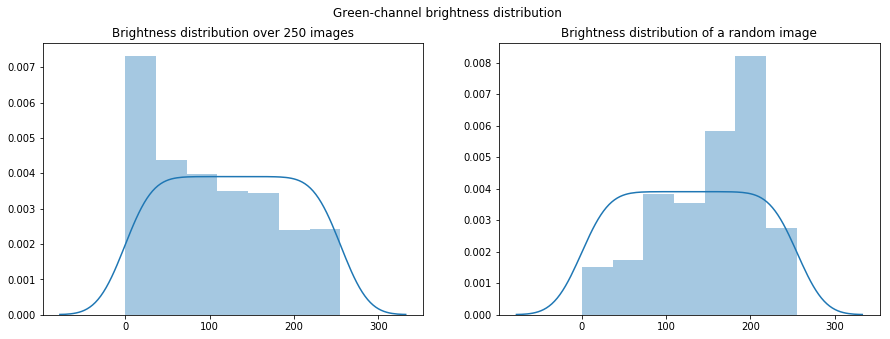

In [3]:
def get_brightness_distribution(channel='green',index=None):
    """
    Arguments:
        channel: ['red', 'green', 'blue']
        index -- image index
    
    Returns:
        pixels_list -- list of pixels of a selected channel; by default of all images
        brightness_distribution -- Series of counts of occurences of each pixel in a pixels_list; 
    
    """
    channel_dict = {'red':0,
                    'green':1,
                    'blue':2}
    try:
        ind = channel_dict[channel]
    except KeyError:
        print(f"channel can be 'red' or 'green' or 'blue'")
        return
    
    if index is not None:
        pixels_list = cv2.split(cv2.imread(sample_images_names[index]))[ind].reshape(-1)
    
    else:
        sample_images_channel = np.array([cv2.split(cv2.imread(img))[ind] for img in sample_images_names])
        pixels_list = np.concatenate([img.flatten() for img in sample_images_channel])   
    bincount = np.bincount(pixels_list)
    
    pixels_value_counts = np.zeros(256,dtype=int)#some images don't contain the brightest pixels and have to be padded
    pixels_value_counts[:bincount.shape[0]] = bincount
    
    brightness_distribution =pixels_value_counts
    #brightness_distribution = pd.Series(data=pixels_value_counts, index=np.arange(256), name=channel)
    
    return pixels_list, brightness_distribution

green_pixels_list, brightness_distribution_green = get_brightness_distribution() #list of all pixels for all images
brightness_distribution_list = [get_brightness_distribution(index=i)[1] for i in range(len(sample_images_names))]# list separate distributions for each image

plt.figure(figsize=(15,5))
plt.suptitle('Green-channel brightness distribution')
plt.subplot(121)
plt.title('Brightness distribution over 250 images')
sns.distplot(np.arange(256),hist_kws={'weights':brightness_distribution_green});#example 


plt.subplot(122)
plt.title('Brightness distribution of a random image')
sns.distplot(np.arange(256),hist_kws={'weights':brightness_distribution_list[42]});#example 

2)	Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:<br>
* 	Математичне очікування та дисперсію:

* In this part we'll calculate all the characteristics for a joint distribution of all images

In [4]:
def calculate_weighted_mean(weights,u=0,k=1):
    return np.average((np.arange(256)-u)**k,weights=weights)
#stats calculation for a specific sample
def calculate_sample_stats(distr, ind):
    mean = calculate_weighted_mean(distr[ind])
    var = calculate_weighted_mean(distr[ind],mean,2)
    skew = calculate_weighted_mean(distr[ind],mean,3)/ (calculate_weighted_mean(distr[ind],mean,2))**(3/2)
    kurt = (calculate_weighted_mean(distr[ind],mean,4)/ (calculate_weighted_mean(distr[ind],mean,2))**2) -3 
    return mean, var, skew, kurt

In [5]:
calculate_sample_stats(brightness_distribution_list,119)

(53.953859649122805,
 3102.607780842457,
 0.7125900416656947,
 -0.6065368837961027)

In [6]:
weightstats = DescrStatsW(np.arange(256),weights=brightness_distribution_green)
avg = np.average(np.arange(256),weights=brightness_distribution_green)
assert avg==green_pixels_list.mean()
np.testing.assert_almost_equal(np.average((np.arange(256)-avg)**2,weights=brightness_distribution_green),np.var(green_pixels_list))

mean, variance = weightstats.mean, weightstats.var
print(f'green channel of 250 images has a mean of {mean:.4f} and a variance of {variance:.4f}')

green channel of 250 images has a mean of 100.9230 and a variance of 5702.3071


* 	Медіану та інтерквартильний розмах;

In [7]:
median,iqr = np.median(green_pixels_list), np.subtract(*np.percentile(green_pixels_list,[75,25]))
print(f'green channel of 250 images has a median of {median} and an IQR of {iqr}')

green channel of 250 images has a median of 90.0 and an IQR of 127.0


* 	Коефіцієнти асиметрії та ексцесу (нормалізований);

In [8]:
skewness,kurtosis = stats.skew(green_pixels_list),stats.kurtosis(green_pixels_list)
print(f'green channel of 250 images has a skew of {skewness:.4f} and kurtosis coeff of {kurtosis:.4f}')

green channel of 250 images has a skew of 0.3841 and kurtosis coeff of -0.9989


* 	Гістограму значень яскравості пікселів (нормалізовану);

3)	Провести обробку отриманих гістограм: 
*	Провести апроксимацію гістограм з використанням імовірнісних розподілів:
 *      i)	Нормального (гаусового) розподілу;
 *      ii)	Розподілу Лапласа;
 *      iii)	Розподілу Стьюдента;
 *      iv)	Бета розподілу;


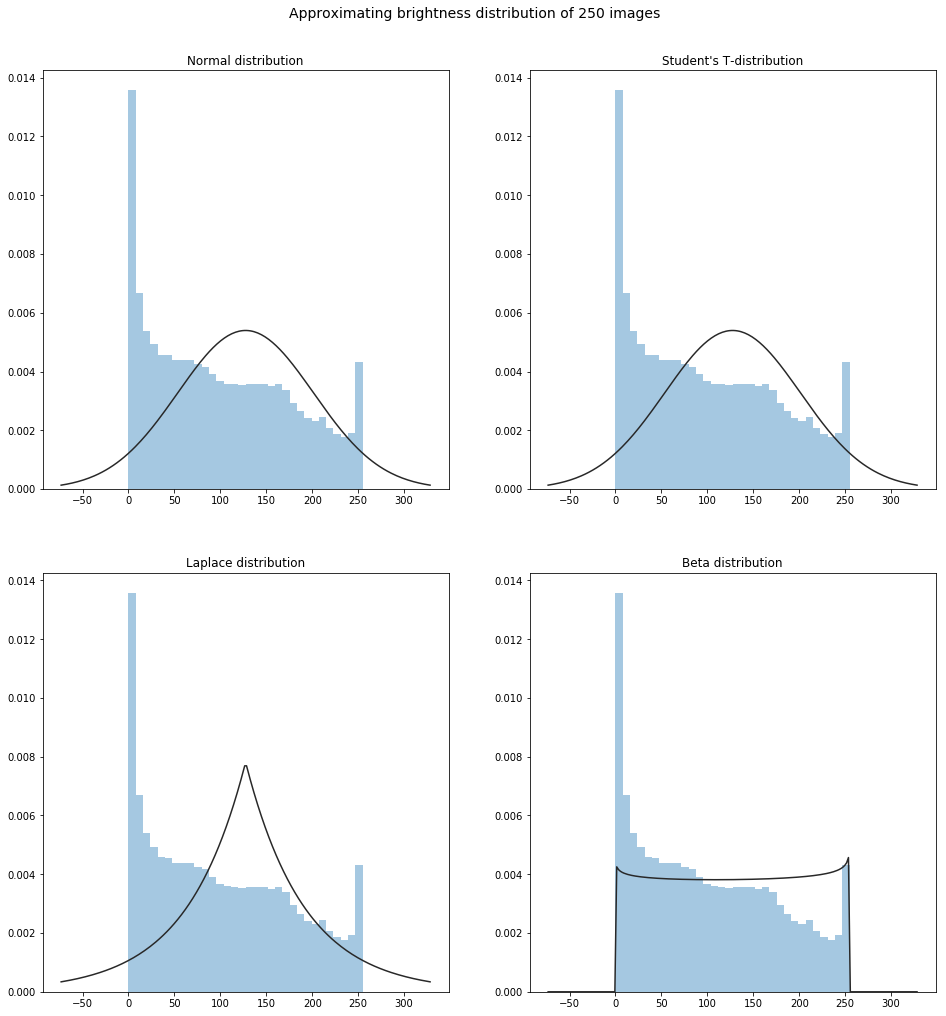

In [9]:
plt.figure(figsize=(16,16))

plt.subplots_adjust(top=0.925)
plt.suptitle('Approximating brightness distribution of 250 images',fontsize=14)
plt.subplot(221)
plt.title("Normal distribution")
sns.distplot(np.arange(256), bins=32, hist_kws={'weights':brightness_distribution_green},norm_hist=True,fit=stats.norm,kde=False) 

plt.subplot(222)
plt.title("Student's T-distribution")
sns.distplot(np.arange(256), bins=32, hist_kws={'weights':brightness_distribution_green},norm_hist=True,fit=stats.t,kde=False) 

plt.subplot(223)
plt.title("Laplace distribution")
sns.distplot(np.arange(256), bins=32, hist_kws={'weights':brightness_distribution_green},fit=stats.laplace,kde=False) 

plt.subplot(224)
plt.title("Beta distribution")
sns.distplot(np.arange(256), bins=32, hist_kws={'weights':brightness_distribution_green},fit=stats.beta,kde=False);

* 	Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;

In [10]:
def calculate_mse(brightness_distribution,distribution='norm'):
    space = np.linspace(0,255,num=256)
    if distribution=='norm':
        pdf = stats.norm.pdf(space,*stats.norm.fit(brightness_distribution))
    elif distribution == "t":
        pdf = stats.t.pdf(space,*stats.t.fit(brightness_distribution))
    elif distribution =='laplace':
        pdf = stats.laplace.pdf(space,*stats.laplace.fit(brightness_distribution))
    elif distribution == 'beta':
        pdf = stats.beta.pdf(space,*stats.beta.fit(brightness_distribution))
        
    predicted = pdf * brightness_distribution.sum()
    return mean_squared_error(brightness_distribution,predicted)

def get_best_dist(brightness_dist):
    distributions = ['norm','t','laplace','beta']
    mse_dict = {d: calculate_mse(brightness_dist,distribution=d) for d in distributions}
    min_dist = min(mse_dict, key=lambda k: mse_dict[k])
    
    return (min_dist, round(mse_dict[min_dist],2))

best_dist_dict = {ind+1: get_best_dist(brightness_distribution_list[ind]) for ind in range(len(brightness_distribution_list))}
best_distribution_df = pd.DataFrame.from_dict(best_dist_dict,orient='index',columns=['Best distribution','MSE'])
best_distribution_df.index.rename('Image',inplace=True)
best_distribution_df

,Best distribution,MSE
Image,,
1,beta,222051.80
2,norm,532780.79
3,laplace,6154256.83
4,norm,867847.62
5,laplace,781983.95
...,...,...
246,t,1048228.48
247,beta,1770899.04
248,laplace,545952.16


*	Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

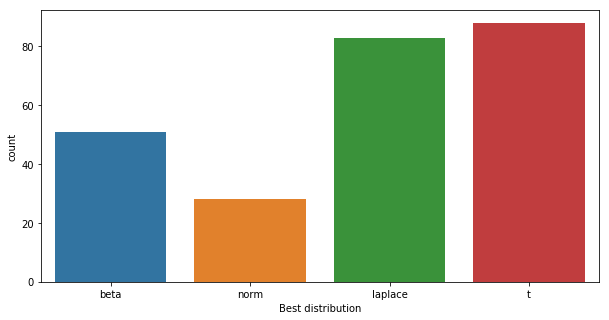

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(best_distribution_df['Best distribution']);

4)	Побудувати багатовимірні гаусові моделі:
*	Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень;
    *   i)	Математичне очікування;
    *   ii)	Математичне очікування та дисперсія;
    *   iii)	Математичне очікування, дисперсія та коефіцієнт асиметрії;
    *    iv)	Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу;


In [12]:
def form_vectors(distribution):
    mean_vector, var_vector, skew_vector, kurt_vector = [],[],[],[]
    
    for i in range(len(distribution)):
        m,v,s,k = calculate_sample_stats(distribution,i)
        
        mean_vector.append(m)
        var_vector.append(v)
        skew_vector.append(s)
        kurt_vector.append(k)
        
    return np.array(mean_vector),np.array(var_vector),np.array(skew_vector),np.array(kurt_vector)

mean_vector, var_vector, skew_vector, kurt_vector = form_vectors(brightness_distribution_list)

*	Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у 
вигляді таблиць.

i) Математичне очікування;

mean_vector:
100.49283121591692,
cov_matrix:
1691.463978456704

estimated pdf: [0.0005 0.0005 0.0005 ... 0.     0.     0.    ]


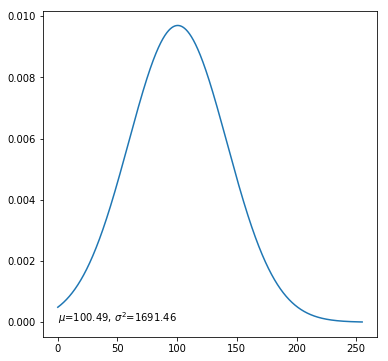

In [13]:
np.set_printoptions(suppress=True,precision=4)

mean_v_1,cov_m_1 = np.mean(mean_vector), np.cov(mean_vector)
x = np.linspace(0,255,5100)
y = stats.norm.pdf(x,mean_v_1,cov_m_1**0.5)
print(f'mean_vector:\n{mean_v_1},\ncov_matrix:\n{cov_m_1}\n\nestimated pdf: {y}')

plt.figure(figsize=(6,6))
plt.plot(x,y)
plt.text(0.3, 0, f'$\mu$={mean_v_1:.2f}, $\sigma^2$={cov_m_1:.2f}');

ii) Математичне очікування та дисперсія;

mean_vector:
[ 100.4928 4000.8261],
cov_matrix:
[[   1691.464    15428.9177]
 [  15428.9177 4113532.6315]]


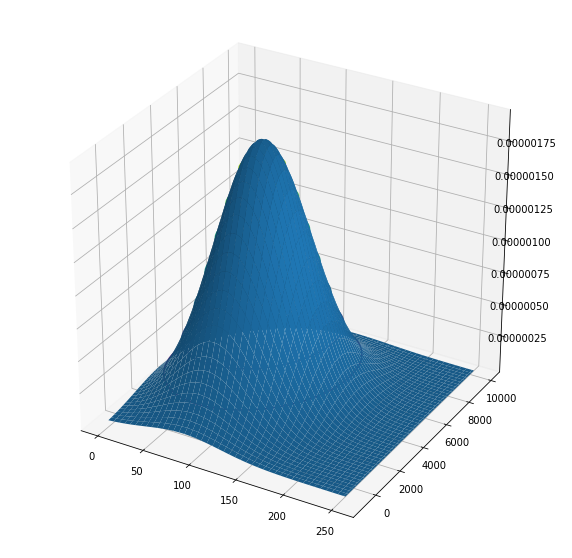

In [14]:
data = np.vstack((mean_vector,var_vector))
mean_v_2,cov_m_2=np.mean(data,axis=1), np.cov(data)

print(f'mean_vector:\n{mean_v_2},\ncov_matrix:\n{cov_m_2}')

x,y = np.mgrid[0:255, -1000:10000]
space = np.empty(x.shape+(2,))
space[:,:,0]=x
space[:,:,1]=y
z = stats.multivariate_normal.pdf(space,mean_v_2,cov_m_2)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
#ax.set_xlim()
#ax.set_ylim()
ax.plot_surface(x,y,z)

plt.contour(x,y,z)
plt.show()

iii) Математичне очікування, дисперсія та коефіцієнт асиметрії;

mean_vector:
[ 100.4928 4000.8261    0.4765],
cov_matrix:
[[   1691.464    15428.9177     -42.434 ]
 [  15428.9177 4113532.6315    -439.6632]
 [    -42.434     -439.6632       1.8177]]


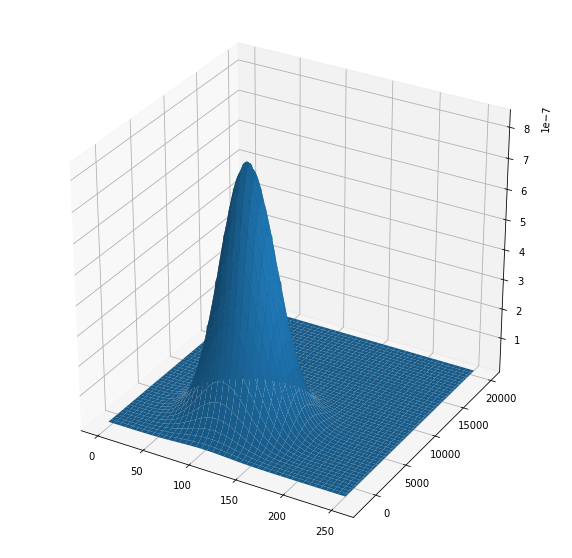

In [15]:
data = np.vstack((mean_vector,var_vector,skew_vector))
mean_v_3,cov_m_3=np.mean(data,axis=1), np.cov(data)

print(f'mean_vector:\n{mean_v_3},\ncov_matrix:\n{cov_m_3}')

x,y = np.mgrid[0:255, -2000:20000]
space = np.empty(x.shape+(3,))
space[:,:,0]=x
space[:,:,1]=y
z = stats.multivariate_normal.pdf(space,mean_v_3,cov_m_3)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)

plt.contour(x,y,z)
plt.show()

iv) Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу;

mean_vector:
[ 100.4928 4000.8261    0.4765    1.4513],
cov_matrix:
[[   1691.464    15428.9177     -42.434     -124.9112]
 [  15428.9177 4113532.6315    -439.6632   -6406.975 ]
 [    -42.434     -439.6632       1.8177      12.7983]
 [   -124.9112   -6406.975       12.7983     191.5563]]


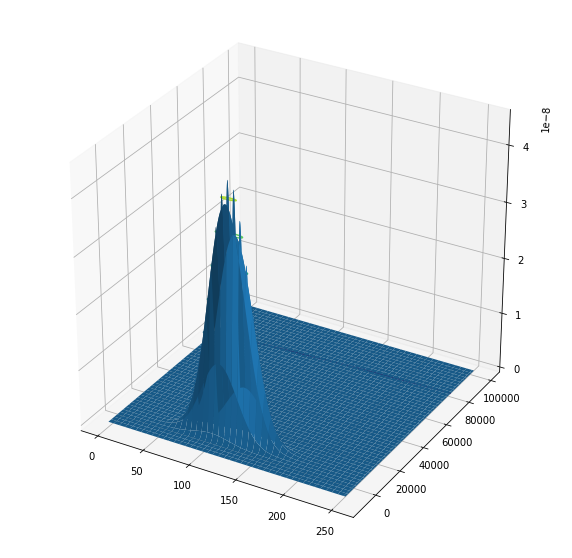

In [16]:
data = np.vstack((mean_vector,var_vector,skew_vector,kurt_vector))
mean_v_4,cov_m_4=np.mean(data,axis=1), np.cov(data)

print(f'mean_vector:\n{mean_v_4},\ncov_matrix:\n{cov_m_4}')

x,y = np.mgrid[0:255, -10000:100000]
space = np.empty(x.shape+(4,))
space[:,:,0]=x
space[:,:,1]=y
z = stats.multivariate_normal.pdf(space,mean_v_4,cov_m_4)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z)

plt.contour(x,y,z)
plt.show()

*   Підготувати звіт за отриманими результатами лабораторної роботи.